In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np

Generate random hypothesis function $h$

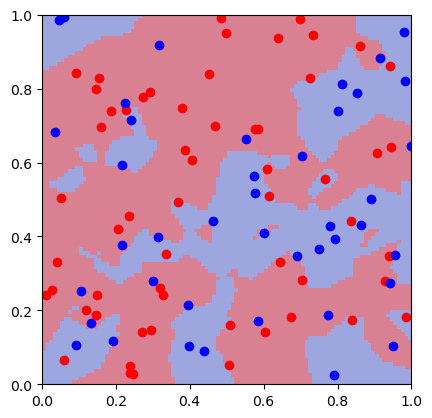

In [6]:
# sample 100 centres uniformly from [0, 1]^2
def generate_S():
    centres = [(random.uniform(0, 1), random.uniform(0, 1)) for _ in range(100)]
    # give each a random label from {0, 1}
    labels = [random.choice([0, 1]) for _ in range(100)]
    return list(zip(centres, labels))

S = generate_S()

def h(x1, x2, S, v):
    # find v nearest centres to (x1, x2) in S and take majority label
    distances_squared_with_labels = [((x1 - cx1) ** 2 + (x2 - cx2) ** 2, label) for (cx1, cx2), label in S]
    distances_squared_with_labels.sort(key=lambda pair: pair[0])    # note: keep labels attached
    v_nearest_labels = [label for _, label in distances_squared_with_labels[:v]]
    zero_count = 0
    for label in v_nearest_labels:
        if label == 0:
            zero_count += 1
    return 0 if zero_count > v / 2 else 1

# split grid [0, 1]^2 into 100x100 cells
x1_vals = np.linspace(0, 1, 100)
x2_vals = np.linspace(0, 1, 100)
# classify each cell using h
v = 3
classified_cells = [[h(x1, x2, S, v) for x1 in x1_vals] for x2 in x2_vals]
# plot the centres with the distribution over hypotheses
plt.imshow(classified_cells, extent=(0, 1, 0, 1), origin='lower', alpha=0.5, cmap='coolwarm')
for (x1, x2), label in S:
    colour = 'red' if label == 1 else 'blue'
    plt.scatter(x1, x2, c=colour)
plt.show()

Estimated generalisation error of k-NN as a function of k

In [ ]:
def sample_from_p_h(S, n):
    samples = []
    for _ in range(n):
        x1 = random.uniform(0, 1)
        x2 = random.uniform(0, 1)
        if random.random() < 0.8:   # flipping the biased coin
            y = h(x1, x2, S, 3)
        else:
            y = random.choice([0, 1])
        samples.append(((x1, x2), y))
    return samples

# TODO: VECTORISE
# using protocol A
generalisation_errors = []
for k in range(1, 50):
    gen_error_sum = 0
    for _ in range(100):
        # sample a h from p_H (generate random points and labels)
        S = generate_S()
        # build k-NN model with 4000 training pts sampled from p_h(x, y)
        training_pts = sample_from_p_h(S, 4000)
        # get curr gen_error for this run using 1000 test pts from p_h(x, y)
        test_pts = sample_from_p_h(S, 1000)
        error_count = 0
        for ((x1, x2), y) in test_pts:
            y_pred = h(x1, x2, training_pts, k) # using k-NN model (training_pts)
            if y_pred != y:     # equivalent to square loss
                error_count += 1
        gen_error = error_count / 1000
        gen_error_sum += gen_error

    generalisation_errors.append(gen_error_sum / 100)

plt.plot(range(1, 50), generalisation_errors)